# Machine Learning Tutorial: k-nearest neighbors 
### By Douglas Hummel-Price
### November 15th, 2019
#### Note: This document contains the code for the tutorial. The markdown cells are rough drafts and contain spelling and similar editing errors. Consult this JN for questions about the creation of the plots and running the model, but consult the word doc for the finalized tutorial

In [42]:
## Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve, train_test_split
from sklearn.metrics import roc_curve, auc

The continually growing data science landscape contains many machine learning tools. Learning how to interpret and validate the reults of these tools can prove quite difficult. This post will explore the model "K-nearest neighbors", or KNN. 

We will first discuss KNN at a high level. We will then apply the model to an artifical dataset of students in a university to attempt to predict whether an individual student lives in one of two dorms. We will use Finally, we will utilize a Receiver Operator Characteristic curve to evaluate the accuracy of the KNN model.
  
  
Note: This tutorial presumes that the reader understands what it means to map variables to points in an n-dimensional space and measure the distance between these points. This tutorial also presumes the reader understand the reason behind a training/test split of data in a statistical learning model. Explaining these would take up too much space in a tutorial about a specific machine learning algorithm. 

For more information about mapping variables to n-dimensional spaces, see:  
<https://towardsdatascience.com/understanding-high-dimensional-spaces-in-machine-learning-4c5c38930b6a>.  

For more information on the logic behind training-test splits, see:   
<https://medium.com/datadriveninvestor/data-science-essentials-why-train-validation-test-data-b7f7d472dc1f>



### An Introduction to KNN
KNN is a **classifier**, meaning that it takes a data set with many *features* (aka indepentent variables) and a single categorical *target* (aka dependent variable). KNN is appropriate when the target is discrete, regardless of whether that target is ordinal. There is no strict maximum number of categories for the target. However, the accuracy of the KNN model, all else equal, requires more data for each additional category, so KNN is typically used for a small number of categories. KNN works best when the features are continous quantitative variables, though dummy variables can be used to turn categorical variables into quantiative ones.     

#### The Logic Behind KNN

Suppose we are on a university campus in which students have a variety of dorms to pick from. Not surprisingly, students with similar interests choose to live together. Atheletes may decide to live in one dorm while artists opt to live in another. Students without major extracuriculars who would prefer a quiet living environment might choose a third dorm. Now suppose we have data on each student: what extracurriculars they do, their grades, major, gender, homestate, and similar information that might be relevant to where that student might choose to live, in addition to the actual dorm that student chose.  

Now suppose we have the same information about the next year of students who have yet to pick their dorms. We are tasked with predicting where these students will live (to ensure that no single dorm will be overpopulated). To do so, we will analyze each new student and attempt to find a set number of students from the previous year with similar characteristics. 

Let's make this more tangible: 
Suppose that the school has 37 total students, 20 artists and 17 athelets. Also suppose the school only has two dorms, the Athletic dorm and the Artistic dorm. In the Athletic dorm, 14 students are active athletes, and the remaining 3 are artists who prefer the atmosphere of the athelete dorm to that of the artist dorm. The artist dorm has 17 active artists and 3 athletes who prefers the artist doorm. Due to their rigorous schedules, most athletes take a predicatable set of big lecture courses and receive GPAs high enough to keep them NCAA-eligible. Artists take a seperate, though similarly predictable set of small seminars and have a much higher variety of GPA, both high and low. We have plotted them on the scatterplot below.

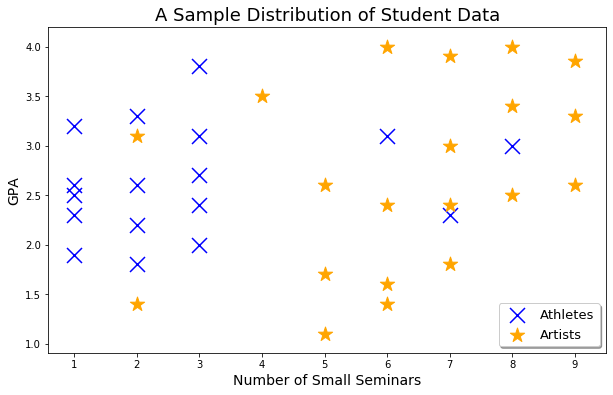

In [293]:
groupa = [(1,3.2),(2,2.6),(3,3.1),(1,2.6),(3,3.8),(1,1.9),(3,2.0),(1,2.5),(2,3.3),(6,3.1),(3,2.4),
          (1,2.3),(2,1.8),(2,2.2),(3,2.7),(8,3.0),(7,2.3)]
groupb = [(6,1.6),(8,3.4),(8,4.0),(6,1.4),(7,3.9),(9,3.85),(4,3.5),(5,1.1),(2,3.1),(8,2.5),(7,3.0),(6,2.4),(5,2.6),
         (6,4.0),(5,1.7),(2,1.4),(7,2.4),(7,1.8),(9,3.3),(9,2.6)]

Aframe = pd.DataFrame(groupa, columns = ["num_sem","gpa"])
Bframe = pd.DataFrame(groupb, columns = ["num_sem","gpa"])
Aframe["group"], Bframe["group"] = 1,0
TestX, TestY = [6],[2.9]

plt.figure(figsize=(10,6))
plt.scatter(x=Aframe["num_sem"], y=Aframe["gpa"], color="b", marker = "x", label="Athletes", s=225)
plt.scatter(x=Bframe["num_sem"], y=Bframe["gpa"], color="orange", marker = "*", label="Artists", s=225)
plt.title("A Sample Distribution of Student Data",fontsize=18)
plt.xlabel("Number of Small Seminars",fontsize=14)
plt.ylabel("GPA",fontsize=14)
plt.legend(loc='lower right', bbox_to_anchor=(0.5, 0.0, 0.5, 0.5),fontsize=13,shadow=True)
plt.savefig("Scatter1.png")
plt.show()

20

We are then presented with a new student. This student takes mostly small seminars, and has an average GPA. Let's add this student to our plot.

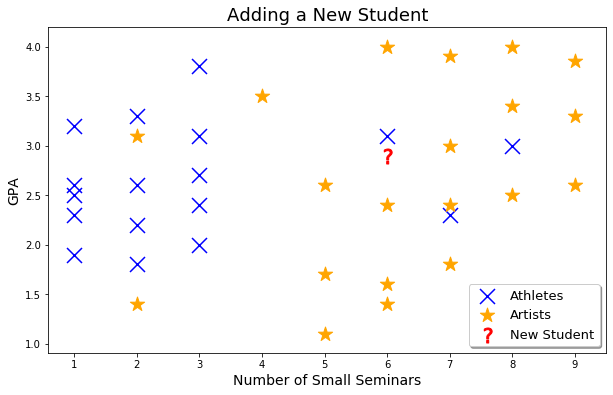

In [294]:
plt.figure(figsize=(10,6))
plt.scatter(x=Aframe["num_sem"], y=Aframe["gpa"], color="b", marker = "x", label="Athletes", s=225)
plt.scatter(x=Bframe["num_sem"], y=Bframe["gpa"], color="orange", marker = "*", label="Artists", s=225)
plt.scatter(x=TestX, y=TestY, color="r", marker="$?$", label="New Student", s=225)
plt.title("Adding a New Student", fontsize=18)
plt.xlabel("Number of Small Seminars",fontsize=14)
plt.ylabel("GPA",fontsize=14)
plt.legend(loc='lower right', bbox_to_anchor=(0.5, 0, 0.5, 0.5),fontsize=13,shadow=True)
plt.savefig("Scatter2.png")
plt.show()

#### The *k*-parameter
In the above example, the number of students similar to our test that we examine is our value for the parameter *k*. Small values of k will be easy to evaluate, but perhaps less accurate. If we set $k=1$, we will only look for the single other student most like our new student. While most students living together are of the same class (athlete vs artist), some students are from the other. This will be quick, but will frequently predict the wrong category. In our example, the closest student to our new student is an athlete, so we predict our new student will also be an athete.  



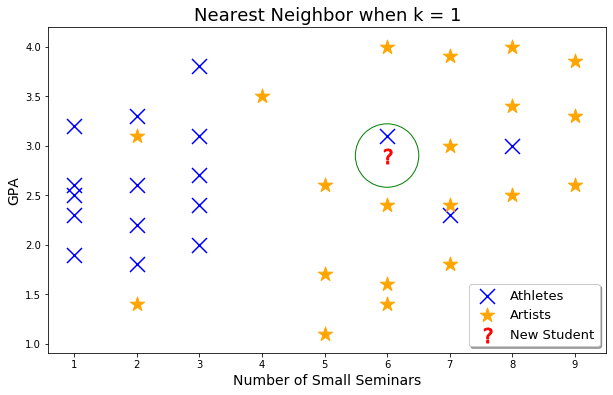

In [295]:
plt.figure(figsize=(10,6))
plt.scatter(x=Aframe["num_sem"], y=Aframe["gpa"], color="b", marker = "x", label="Athletes", s=225)
plt.scatter(x=Bframe["num_sem"], y=Bframe["gpa"], color="orange", marker = "*", label="Artists", s=225)
plt.scatter(x=TestX, y=TestY, color="r", marker="$?$", label="New Student", s=225)
plt.scatter(x=6, y=2.9, color="Green", facecolor='none', marker="o", s=4025)
plt.title("Nearest Neighbor when k = 1",fontsize=18)
plt.xlabel("Number of Small Seminars",fontsize=14)
plt.ylabel("GPA",fontsize=14)
plt.legend(loc='lower right', bbox_to_anchor=(0.5, 0, 0.5, 0.5),fontsize=13,shadow=True)
plt.savefig("Scatter3.png")
plt.show()

However, if we increase the number of students to four ($k=4$), we now notice that we now have 3 artists in additional to the athlete, all of whom live in the artist dorm. When the k-nearest neighbors to our test point are of multiple types, we pick the modal type. We would now correctly classify the new student as an artist-drom student. In this instance, identifying the four closest students will take longer than simply identifying the first. We have traded a shorter processing time for a more accurate model. 

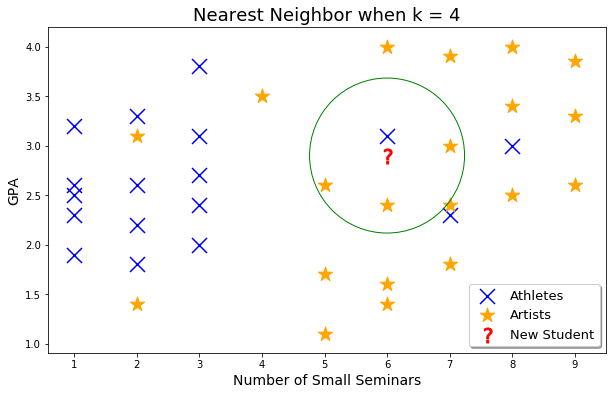

In [296]:
plt.figure(figsize=(10,6))
plt.scatter(x=Aframe["num_sem"], y=Aframe["gpa"], color="b", marker = "x", label="Athletes", s=225)
plt.scatter(x=Bframe["num_sem"], y=Bframe["gpa"], color="orange", marker = "*", label="Artists", s=225)
plt.scatter(x=TestX, y=TestY, color="r", marker="$?$", label="New Student", s=225)
plt.scatter(x=6, y=2.9, color="Green", facecolor='none', marker="o", s=24025)
plt.title("Nearest Neighbor when k = 4",fontsize=18)
plt.xlabel("Number of Small Seminars",fontsize=14)
plt.ylabel("GPA",fontsize=14)
plt.legend(loc='lower right', bbox_to_anchor=(0.5, 0, 0.5, 0.5),fontsize=13,shadow=True)
plt.savefig("Scatter4.png")
plt.show()

As we increase *k*, we will generally get more accurate results but each computation will take more and more time. At a certain point (say when k=24, the size of both dorms combined), our model will be less accurate again. Due to idiosynchracies in our data, certain values of k will be more accruate than others. Therefore, we ultimately must decide our value of k based on the accruacy of that model produced by that particular value weighed against the computation time for that value. 

Note: KNN evaluates closest neighbors by calculating the euclidian distance from the test point to each other point. The green circle in the above plots is for illistrative purposes only. (The model starts with points and calculates distances rather than looking for points at a certain distance and then increasing that distance, rather than using something like a circle around the test point)

### Applying KNN using NASA Data
We will now shift from our university hypothetical to a real-world application. The rest of this tutorial will use NASA contract data 2017 combined with state level data from the same time. The data for this next section was wrangled and cleaned in the Jupyter Notebook call "Data_Cleaning_and_Merging". 

We will use KNN to attempt to predict whether a given state has one a Senator sitting on the Senate Commerce Subcommittee on Space, Science, and Competitiveness. (The committee has morphed into the Subcommittee on Aviation and Space in the 116th Congress) Has_Facility is a dummy variable representing whether a state has a NASA facility (1=has a facility)

In [228]:
data = pd.read_csv("Cleaned_2017_NASA_POP_INFMORT.csv")

#### Training-Test Split

As with most machine learning models, our first step in applying our model is creating a training-test split in the data. This allows us to train the model on some of the data and test the accuracy of our model on the test data. We'll use the train_test_split function in scikitlearn to do this automatically for us. Normally, a training-test split is either 80-20 or 90-10, but for illistratrative purposes, I've done a 70-30 split. 

Our feature matrix, the dataframe that contains our independent variables, consists of the following for each state in 2017: the logged population, the infant mortality rate, the number of infant deaths, a dummy variable representing whether the state is in the top ten states with the highest NASA contract award totals (1=yes), and a dummy varible representing whether the state has a NASA facility within it (1=yes). 

In [297]:
X = data[["Logged_pop","Rate","Deaths","Top_Ten","Has_Facility"]]
y = data["Senate"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.30,random_state=42)

In [298]:
X.head()

,Logged_pop,Rate,Deaths,Top_Ten,Has_Facility
0,13.514116,5.6,59,0,0
1,15.399655,7.4,434,1,1
2,14.915121,8.2,307,0,0
3,15.768379,5.7,469,0,0
4,17.489260,4.2,1973,1,1


The accuracy score for k=1 is: 0.7333333333333333
The AUC for k=1:  0.6346153846153846


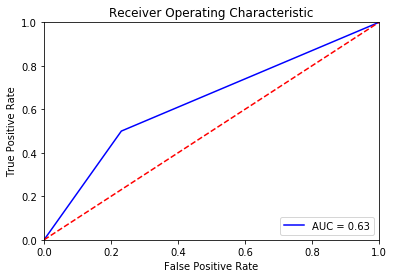

In [264]:
k1 = KNeighborsClassifier(n_neighbors=1)
k1.fit(X_train,y_train)
y_predict_k1 = k1.predict(X_test)
score = accuracy_score(y_test,y_predict_k1)
print(f"The accuracy score for k=1 is: {score}")

# true positives and false positives
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_k1, pos_label=1)
rates = pd.DataFrame(dict(fpr=false_positive_rate, tpr=true_positive_rate))
roc_auc = auc(rates['fpr'], rates['tpr'])
print('The AUC for k=1: ', roc_auc)

plt.plot(rates.fpr, rates.tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

The accuracy score for k=4 is: 0.8666666666666667
The AUC for k=1:  0.5


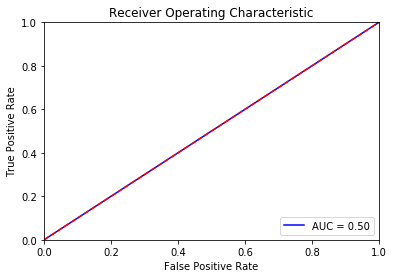

In [265]:
k4 = KNeighborsClassifier(n_neighbors=4)
k4.fit(X_train,y_train)
y_predict_k4 = k4.predict(X_test)
score = accuracy_score(y_test,y_predict_k4)
print(f"The accuracy score for k=4 is: {score}")

# true positives and false positives
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_k4, pos_label=1)
rates = pd.DataFrame(dict(fpr=false_positive_rate, tpr=true_positive_rate))
roc_auc = auc(rates['fpr'], rates['tpr'])
print('The AUC for k=1: ', roc_auc)

plt.plot(rates.fpr, rates.tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

The accuracy score for k=1: 0.7333333333333333
The AUC for k={k}:  0.6346153846153846


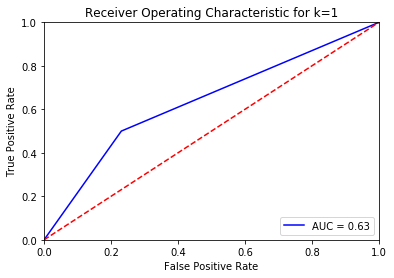

The accuracy score for k=2: 0.8
The AUC for k={k}:  0.46153846153846156


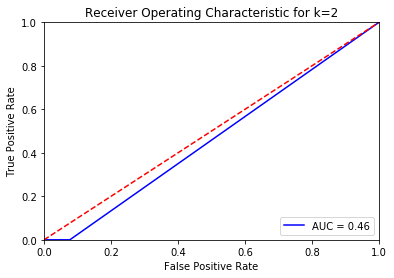

The accuracy score for k=3: 0.8
The AUC for k={k}:  0.46153846153846156


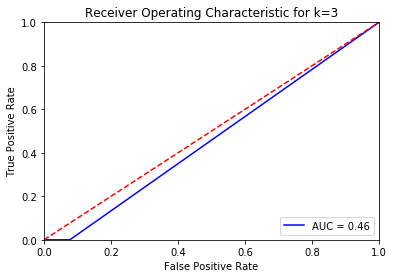

The accuracy score for k=4: 0.8666666666666667
The AUC for k={k}:  0.5


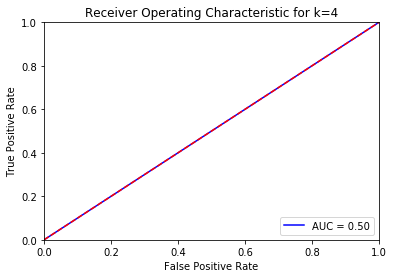

The accuracy score for k=5: 0.9333333333333333
The AUC for k={k}:  0.75


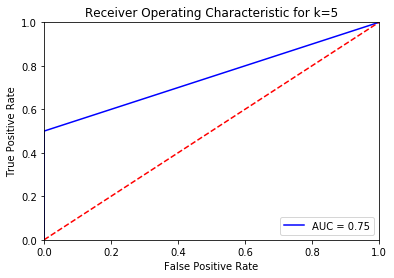

The accuracy score for k=6: 0.8666666666666667
The AUC for k={k}:  0.5


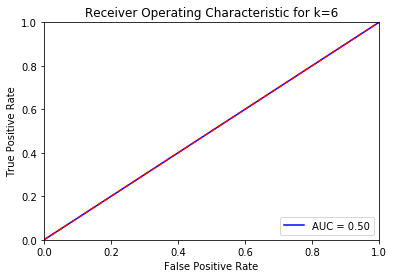

The accuracy score for k=7: 0.8666666666666667
The AUC for k={k}:  0.5


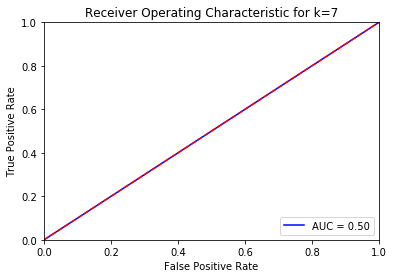

The accuracy score for k=8: 0.8666666666666667
The AUC for k={k}:  0.5


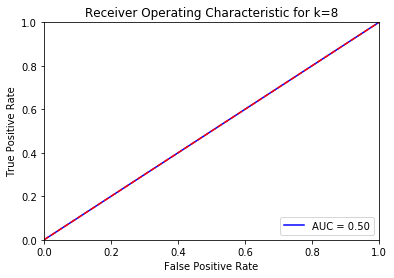

The accuracy score for k=9: 0.7333333333333333
The AUC for k={k}:  0.4230769230769231


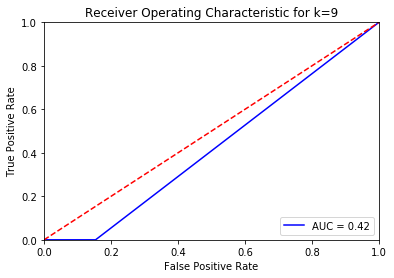

The accuracy score for k=10: 0.8666666666666667
The AUC for k={k}:  0.5


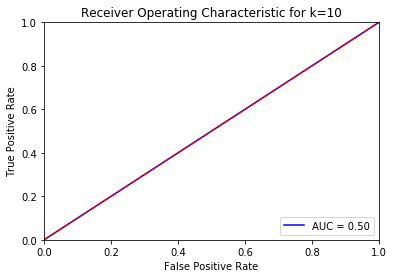

The accuracy score for k=11: 0.8
The AUC for k={k}:  0.46153846153846156


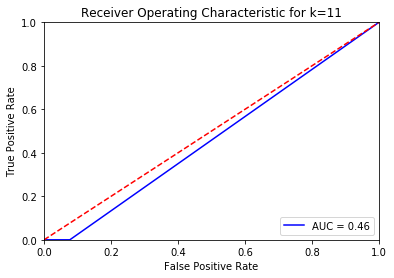

The accuracy score for k=12: 0.8666666666666667
The AUC for k={k}:  0.5


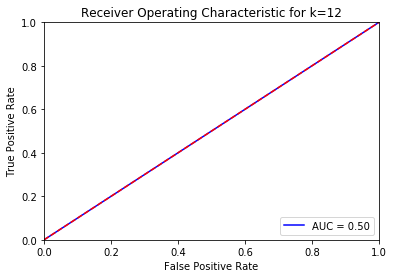

The accuracy score for k=13: 0.8
The AUC for k={k}:  0.46153846153846156


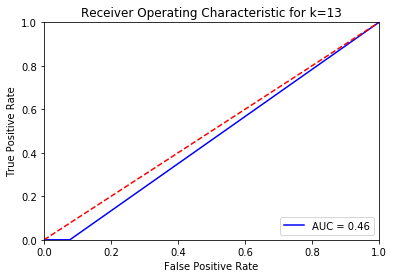

The accuracy score for k=14: 0.8666666666666667
The AUC for k={k}:  0.5


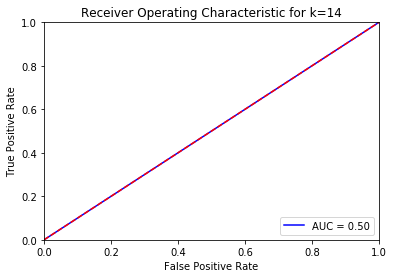

The accuracy score for k=15: 0.8666666666666667
The AUC for k={k}:  0.5


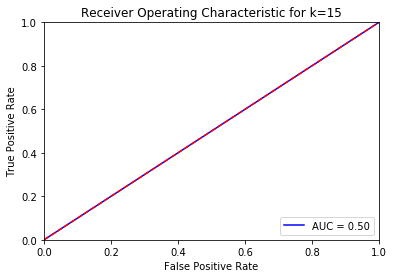

The accuracy score for k=16: 0.8666666666666667
The AUC for k={k}:  0.5


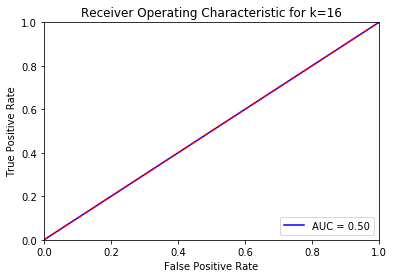

The accuracy score for k=17: 0.8666666666666667
The AUC for k={k}:  0.5


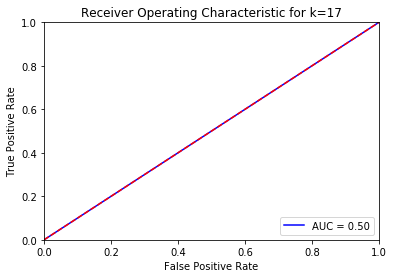

The accuracy score for k=18: 0.8666666666666667
The AUC for k={k}:  0.5


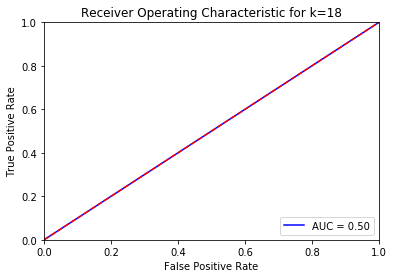

The accuracy score for k=19: 0.8666666666666667
The AUC for k={k}:  0.5


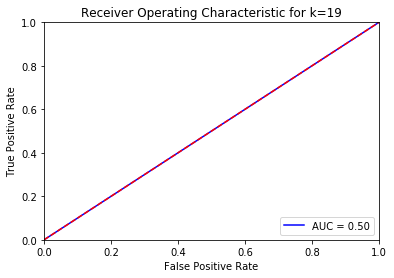

In [283]:
for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_predict_knn = knn.predict(X_test)
    score = accuracy_score(y_test,y_predict_knn)
    print(f"The accuracy score for k={k}: {score}")

    # true positives and false positives
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_knn, pos_label=1)
    rates = pd.DataFrame(dict(fpr=false_positive_rate, tpr=true_positive_rate))
    roc_auc = auc(rates['fpr'], rates['tpr'])
    print('The AUC for k={k}: ', roc_auc)

    plt.plot(rates.fpr, rates.tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'Receiver Operating Characteristic for k={k}')
    plt.legend(loc = 'lower right')
    plt.show()

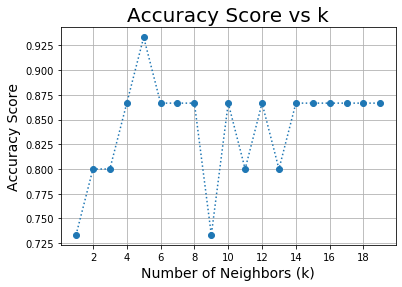

In [292]:
X_vals=range(1,20)
Y_vals=[]

for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_predict_knn = knn.predict(X_test)
    score = accuracy_score(y_test,y_predict_knn)
    Y_vals.append(score)
    
plt.title("Accuracy Score vs k",fontsize=20) 
plt.xlabel("Number of Neighbors (k)",fontsize=14)
plt.ylabel("Accuracy Score",fontsize=14)
plt.xticks(range(0,20,2))    
plt.grid()
plt.plot(X_vals,Y_vals,marker="o", linestyle= ":")
plt.savefig("Accuracy_Score_vs_k.png");

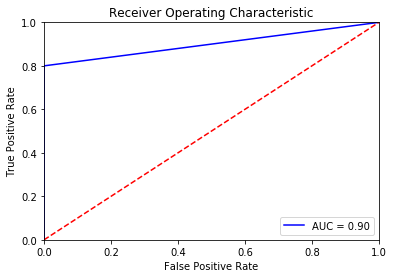

In [44]:
plt.plot(rates.fpr, rates.tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

In [49]:
# true positives and false positives
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_k4, pos_label=1)
rates = pd.DataFrame(dict(fpr=false_positive_rate, tpr=true_positive_rate))
roc_auc = auc(rates['fpr'], rates['tpr'])
print('The AUC for k=1: ', roc_auc)

The AUC for k=1:  0.8857142857142858


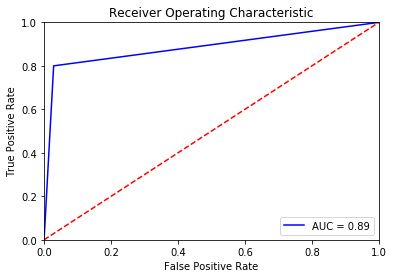

In [50]:
plt.plot(rates.fpr, rates.tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()